# New Analysis (Job Prep and Review)

In [56]:
import pandas as pd
import warnings
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras
from keras import layers
from IPython.display import clear_output
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from numpy.random import seed
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import pulse_functions as pf
from pyts.classification import BOSSVS
from pyts.transformation import BOSS
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import csv

In [11]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## Data Pull in

In [12]:
with open('../data-cleaned/train1.pickle', 'rb') as f:
    train1 = pickle.load(f)
    
with open('../data-cleaned/train2.pickle', 'rb') as f:
    train2 = pickle.load(f)
    
with open('../data-cleaned/test.pickle', 'rb') as f:
    test = pickle.load(f)
    
# train = train1 | train2 

train = {**train1, **train2}

In [13]:
columns = ['A+ IGBT I', 'C Phase DV', 'A+* IGBT I', 'Spare 2', 'B+ IGBT I',
       'Spare 3', 'B+* IGBT I', 'Spare 4', 'C+ IGBT I', '+ CB I', 'C+* IGBT I',
       '- CB I', '+ CB V', '- CB V', 'MOD I', 'DTL MPS 1 I', 'AC L1 I',
       'A FLUX', 'AC L1 V', 'DTL1 Kly', 'AC L2 I', 'B FLUX', 'AC L2 V',
       'DTL2 Kly', 'AC L3 I', 'C FLUX', 'AC L3 V', 'Gate In', 'MOD V', 'DV/DT',
       '+ DC I', '- DC I']
useful_cols = ['A+ IGBT I', 'A+* IGBT I', 'B+ IGBT I',
       'B+* IGBT I', 'C+ IGBT I', '+ CB I', 'C+* IGBT I',
       '- CB I', '+ CB V', '- CB V', 'MOD I', 'DTL MPS 1 I',
       'A FLUX', 'DTL1 Kly', 'B FLUX',
       'DTL2 Kly', 'C FLUX', 'MOD V', 'DV/DT']

In [74]:
len(useful_cols)

19

In [75]:
y_type

NameError: name 'y_type' is not defined

## Functions

In [14]:
def Data_pulling_in_NEW():
    '''
    MUST BE RE-Run Each time you do a CV split since the CV code uses a .pop method
    Take in data and combines the training / test so we can do cross validation (small sample size so doing CV instead of train/test)
    '''
    ## Pulling Raw Data in 
    X_raw, y_fault, y_type, indicies_raw = pf.get_all_pulses(train, useful_cols, reshape=None)
    X_raw_test, y_fault_test, y_type_test, indicies_raw_test = pf.get_all_pulses(test, useful_cols, reshape=None)
    
    ## removing index 59 (breaks the BOSS transformation, not sure why)
    X_raw_cleaned = np.delete(X_raw, 59, axis=0)
    y_fault_cleaned = np.delete(y_fault, 59, axis=0)
    y_type_cleaned = np.delete(y_type, 59, axis=0)
    indicies_raw_list = indicies_raw[0]
    indicies_raw_list.pop(59)
    
    ## Doing combinations 
    # X_raw
    combined_X_data = np.concatenate((X_raw_cleaned, X_raw_test))
    # y_faults
    combined_y_faults = np.concatenate((y_fault_cleaned, y_fault_test))
    # y_type
    combined_y_type = np.concatenate((y_type_cleaned, y_type_test))
    ## Getting indices
    # train_indices = indicies_raw[0]
    test_indices = indicies_raw_test[0]
    indicies_raw_list.extend(test_indices)
    combined_indices = indicies_raw_list
    
    return combined_X_data, combined_y_faults, combined_y_type, combined_indices


def train_test_val_split(random_parm = 1):
    '''
    Given a random state, shuffles data accordingly
    '''
    combined_X_data_shuffled, combined_y_faults_shuffled, combined_y_type_shuffled, combined_indices_shuffled = shuffle(combined_X_data, combined_y_faults,
                                                                                                                     combined_y_type, combined_indices, random_state=random_parm)
    X_train = combined_X_data_shuffled[0:126]
    y_train = combined_y_faults_shuffled[0:126]

    X_val = combined_X_data_shuffled[126:167]
    y_val = combined_y_faults_shuffled[126:167]

    X_test = combined_X_data_shuffled[167:]
    y_test = combined_y_faults_shuffled[167:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, combined_y_type_shuffled, combined_indices_shuffled


def BOSS_transformation(X_train, X_val, X_test, word_size=3, n_bins=2):
    '''
    BOSS transformation that can be tuned on word and bin size, takes in the X data and transforms. 
    '''
    
    boss = BOSS(word_size=word_size, n_bins=n_bins, sparse=False, numerosity_reduction=False)
    
    ## transforming Train
    X_train_swaped = np.swapaxes(X_train,0,1)

    boss_list_train = []
    for parameter in X_train_swaped:
        local_boss = boss.fit_transform(parameter)
        boss_list_train.append(local_boss)
    boss_array_train = np.array(boss_list_train)

    X_train_BOSS_transformed = np.swapaxes(boss_array_train,1,0)

    ## transforming val
    X_val_swaped = np.swapaxes(X_val,0,1)

    boss_list_val = []
    for parameter in X_val_swaped:
        local_boss = boss.fit_transform(parameter)
        boss_list_val.append(local_boss)
    boss_array_val = np.array(boss_list_val)

    X_val_BOSS_transformed = np.swapaxes(boss_array_val,1,0)

    ## transforming Test
    X_test_swaped = np.swapaxes(X_test,0,1)

    boss_list_test = []
    for parameter in X_test_swaped:
        local_boss = boss.fit_transform(parameter)
        boss_list_test.append(local_boss)
    boss_array_test = np.array(boss_list_test)

    X_test_BOSS_transformed = np.swapaxes(boss_array_test,1,0)
    
    return X_train_BOSS_transformed, X_val_BOSS_transformed, X_test_BOSS_transformed


def flatten_and_normalize(X_train_BOSS_transformed,X_val_BOSS_transformed,X_test_BOSS_transformed):
    '''
    flatten and normalize all X data to use as input for autoencoder
    '''
    # getting normalizing factor
    noamlizing_factor = np.sum(X_train_BOSS_transformed[0][0])

    ## Flatten
    flatten_list_train = []
    for ob in X_train_BOSS_transformed:
        ob_flatten = ob.flatten()
        flatten_list_train.append(ob_flatten)
    flatten_X_train = np.array(flatten_list_train)

    flatten_list_val = []
    for ob in X_val_BOSS_transformed:
        ob_flatten = ob.flatten()
        flatten_list_val.append(ob_flatten)
    flatten_X_val = np.array(flatten_list_val)

    flatten_list_test = []
    for ob in X_test_BOSS_transformed:
        ob_flatten = ob.flatten()
        flatten_list_test.append(ob_flatten)
    flatten_X_test = np.array(flatten_list_test)

    # Normalize
    flatten_X_train_normalized = flatten_list_train/noamlizing_factor
    flatten_X_val_normalized = flatten_list_val/noamlizing_factor
    flatten_X_test_normalized = flatten_list_test/noamlizing_factor
    
    return flatten_X_train_normalized, flatten_X_val_normalized, flatten_X_test_normalized


def final_evaluation_LDA(flatten_X_train_normalized, flatten_X_test_normalized, y_train, y_test):
    '''
    Uses the true lables of train and test to fit and then evaluation LDA model
    '''
    latent_representation_train = encoder.predict(flatten_X_train_normalized) 
    latent_representation_test = encoder.predict(flatten_X_test_normalized)

    ## LDA
    clf = LinearDiscriminantAnalysis()
    clf.fit(latent_representation_train, y_train)
    predictions = clf.predict(latent_representation_test)
    cm = confusion_matrix(y_test, predictions)

    ## NOTE, sklearn does this a little different than most cm
    TP = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[0][0]
    total_count = np.sum(cm)

    accuracy = (TP + TN)/total_count
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = (Precision*Recall)/(Precision+Recall)

    return cm, accuracy, Precision, Recall, F1

def get_results_df(cm):
    '''
    given the cm for a knn, get the final results
    '''
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    Prec = TP / (TP+FP)
    Recall = TP / (TP+FN)
    F1 = 2 * ((Prec*Recall)/(Prec+Recall))
    
    # results_list  = [(TP+TN)/np.sum(cm), Prec, Recall, F1, seed, k, encoding_dim ]

    results_df = pd.DataFrame({'Accuracy': (TP+TN)/np.sum(cm),
                               'Precision': Prec,
                               'Recall':Recall,
                               'F-1 Score':F1}, index=[0])
    return results_df


def get_grading(predictions, true_lable):
    '''
    Given predictions, can get the true lables of data
    '''
    results_list = []
    for ob in range(0,len(predictions)):
        if (predictions[ob] == 1 and true_lable[ob] == 1):
            results_list.append('TP')
        elif (predictions[ob] == 1 and true_lable[ob] == 0):
            results_list.append('FP')
        elif (predictions[ob] == 0 and true_lable[ob] == 0):
            results_list.append('TN')
        else:
            results_list.append('FN')
    return results_list

## FINAL Analysis SINGLE PASS

In [83]:
np.unique(combined_y_type).shape

(14,)

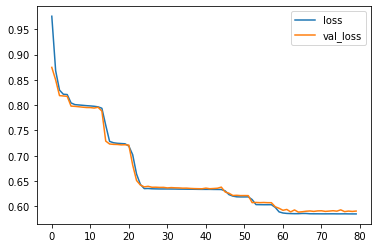

In [15]:
## DATA Pull in
combined_X_data, combined_y_faults, combined_y_type, combined_indices = Data_pulling_in_NEW()

######################################################
## intial set up and transformation
######################################################

seed = 7
k = 1
encoding_dim = 3
X_train, y_train, X_val, y_val, X_test, y_test, combined_y_type_shuffled, combined_indices_shuffled = train_test_val_split(seed)
X_train_BOSS_transformed, X_val_BOSS_transformed, X_test_BOSS_transformed = BOSS_transformation(X_train, X_val, X_test, word_size=3, n_bins=2)

######################################################
## Setting up pass of the autoencoder
######################################################

# Defining the shapes
flatten_shape = X_train_BOSS_transformed[0].shape[0] * X_train_BOSS_transformed[0].shape[1]
encod_1 = int(flatten_shape/2)
encod_2 = 48
encod_3 = 32
encoding_dim = encoding_dim 
decod_1 = encod_3
decod_2 = encod_2
decod_3 = encod_1


# intital creation of model:
# autoencoder = keras.Sequential()

# This is our input image
input_img = keras.Input(shape=(flatten_shape, ))

# encoding layers
encoding_layer_1 = layers.Dense(encod_1)(input_img)
encoding_layer_1_a = layers.LeakyReLU(alpha=0.1)(encoding_layer_1)

encoding_layer_2 = layers.Dense(encod_2)(encoding_layer_1_a)
encoding_layer_2_a = layers.LeakyReLU(alpha=0.1)(encoding_layer_2)

encoding_layer_3 = layers.Dense(encod_3)(encoding_layer_2_a)
encoding_layer_3_a = layers.LeakyReLU(alpha=0.1)(encoding_layer_3)

# "encoded" is the encoded representation of the input. Also can think of as the latent space
encoded = layers.Dense(encoding_dim, activation='relu')(encoding_layer_3_a)
encoded_a = layers.LeakyReLU(alpha=0.3)(encoded)
# encoded = layers.Dense(encoding_dim, activation='relu')(encoding_layer_3)

# decoding layers
decoding_layer_1 = layers.Dense(encod_3, activation='relu')(encoded_a)
decoding_layer_1_a = layers.LeakyReLU(alpha=0.1)(decoding_layer_1)


decoding_layer_2 = layers.Dense(encod_2, activation='relu')(decoding_layer_1_a)
decoding_layer_2_a = layers.LeakyReLU(alpha=0.1)(decoding_layer_2)

decoding_layer_3 = layers.Dense(encod_1, activation='relu' )(decoding_layer_2_a)
decoding_layer_3_a = layers.LeakyReLU(alpha=0.1)(decoding_layer_3)

# This is our output image
# output_img = layers.Dense(flatten_shape)(edecoding_layer_3_a)

# "decoded" is the lossy reconstruction of the input
# decoded = layers.LeakyReLU(alpha=0.1)(decoding_layer_3)
decoded = layers.Dense(flatten_shape, activation='relu')(decoding_layer_3_a)


# This model maps an input to its reconstruction (Full model)
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation (input to latent space)
encoder = keras.Model(input_img, encoded_a)

# optimizer and loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  


print(autoencoder.summary())

######################################################
## flatten / normalize and then fit encoder 
######################################################

flatten_X_train_normalized, flatten_X_val_normalized, flatten_X_test_normalized = flatten_and_normalize(X_train_BOSS_transformed,X_val_BOSS_transformed,X_test_BOSS_transformed)

autoencoder.fit(flatten_X_train_normalized, flatten_X_train_normalized,
                                epochs=80,
                                batch_size=4,
                                shuffle=True,
                                verbose=1,
                                callbacks=[plot_losses],
                                validation_data=(flatten_X_val_normalized, flatten_X_val_normalized))


In [16]:
## geting latent representations

latent_representation_train = encoder.predict(flatten_X_train_normalized) 
latent_representation_val = encoder.predict(flatten_X_val_normalized) 
latent_representation_test = encoder.predict(flatten_X_test_normalized)

latent_test_val_representation = np.concatenate((latent_representation_val, latent_representation_test), axis=0)
val_test_y = np.concatenate((y_val, y_test), axis=0)

In [17]:
## SVM

### parameter tuning from training data:

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


F1_scorer = make_scorer(f1_score)

grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv, scoring=F1_scorer)
grid.fit(latent_representation_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

## fitting on full training
rbf_svc = svm.SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
rbf_svc.fit(latent_representation_train,y_train)

The best parameters are {'C': 10.0, 'gamma': 1000.0} with a score of 0.82


SVC(C=10.0, gamma=1000.0)

In [18]:
## seeing how it does with training
training_predictions = rbf_svc.predict(latent_representation_train)
cm_train = confusion_matrix(y_train, training_predictions)
get_results_df(cm_train)

,Accuracy,Precision,Recall,F-1 Score
0,0.928571,1.0,0.689655,0.816327


In [19]:
## seeing how it does with test
test_validation_predictions = rbf_svc.predict(latent_test_val_representation)
cm_test_val = confusion_matrix(val_test_y, test_validation_predictions)
get_results_df(cm_test_val)

,Accuracy,Precision,Recall,F-1 Score
0,0.876543,0.866667,0.619048,0.722222


## Vis

In [72]:
## Train Vis:
training_classifications = get_grading(training_predictions, y_train)
y_train_type = combined_y_type_shuffled[0:126]


train_data_latent_space = pd.DataFrame({'Node 0': latent_representation_train.T[0],
                                       'Node 1': latent_representation_train.T[1],
                                       'Node 2': latent_representation_train.T[2],
                                       'Classification Results': training_classifications, 
                                       'Fault Type':y_train_type})


fig = px.scatter_3d(pd.DataFrame(train_data_latent_space), x='Node 0', 
                    y='Node 1', z='Node 2',
                color='Classification Results',
                    hover_data = ['Fault Type'],
                color_discrete_map={
                'TN': 'blue',
                'TP': 'green', 
                'FP': 'orange',
                'FN': 'red'} 
                   )
fig.update_layout(title_text='Training Data Latent Space', title_x=0.5)

fig.show()

In [73]:
## Test
test_val_classifications = get_grading(test_validation_predictions, val_test_y)
y_val_test_type = combined_y_type_shuffled[126:]

test_data_latent_space = pd.DataFrame({'Node 0': latent_test_val_representation.T[0],
                                       'Node 1': latent_test_val_representation.T[1],
                                       'Node 2': latent_test_val_representation.T[2],
                                       'Classification Results': test_val_classifications,
                                        'Fault Type':y_val_test_type})

fig = px.scatter_3d(pd.DataFrame(test_data_latent_space), x='Node 0',y='Node 1',z='Node 2',
                   color='Classification Results', 
                    hover_data = ['Fault Type'],
                color_discrete_map={
                'TN': 'blue',
                'TP': 'green', 
                'FP': 'orange',
                'FN': 'red'})
fig.update_layout(title_text='Test Data Latent Space', title_x=0.5)
fig.show()

In [61]:
## saving the latent space representations in csv file
# train_data_latent_space.to_csv('Train_data_latent_df.csv')
# test_data_latent_space.to_csv('Test_data_latent_df.csv')
